### Importamos paquetes requeridos

In [ ]:
import os
from os.path import join

# packages for plotting graphs
import matplotlib.pyplot as plt

# packages for model train / validation
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

### Primeros pasos:
Verificamos acceso a imagenes

In [ ]:
DATA_PATH = 'data'

In [ ]:
dog_img_name = join(DATA_PATH, 'train/dog/0.jpg')
dog_img = plt.imread(dog_img_name)
plt.imshow(dog_img)

In [ ]:
cat_img_name = join(DATA_PATH, 'train/cat/0.jpg')
cat_img = plt.imread(cat_img_name)
plt.imshow(cat_img)

### Preparamos los datos para entrenamiento
- Definimos las dimensiones de las imagenes 32 x 32 (para que el entrenamiento sea más rápido!)

In [ ]:
img_width, img_height = 32, 32

- Definimos cual será el el shape de mis imagenes: 32 x 32 x 3 -> 3 significa RGB
- Dependiendo del backend engine usado por Keras, la definición del `input_shape` puede cambiar

In [ ]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

### Crear red neunoral para Clasificar Imágenes

No utilizamos Artifitial Neural Network (ANN) porque es díficil realizar clasificación de imagenes.

Usamos una Convolutional Neural Network (CNN) porque ofrece ventajas sobre una ANN para esta tarea:

- Utiliza filtros convonucionales para extraer caracteristicas agrupando pixeles que se encuentran en la misma ubicación
- Ayuda a reducir las dimensiones de la representación de cada imagen usando Pooling antes de ser procesadas por las siguientes layers

La CNN que estamos creando cuenta con 2 partes:
1. Features Extraction (Convolution + ReLU + Pooling): 
    - Convolution para las carácteristicas (orejas, nariz, ojos, cabeza, etc) usando filtros Conv2D (3x3)
    - ReLU activation para reducir la complejidad de algunos calculos dentro de mi ANN
    - Pooling ayuda a reducir las dimensiones de mi output
2. Classification (regular densely-connected NN layers):
    - Usamos Dense neural network con hidden layer de 64 neuronas
    - ReLU activation nuevamente
    - Dropout 50%
    - Output layer con una neurona + función de activación `sigmoid`
    - Responsable por clasificación

Para entender mejor, recomiendo estos enlaces:
- https://www.youtube.com/watch?v=zfiSAzpy9NM&ab_channel=codebasics
- https://towardsdatascience.com/conv2d-to-finally-understand-what-happens-in-the-forward-pass-1bbaafb0b148

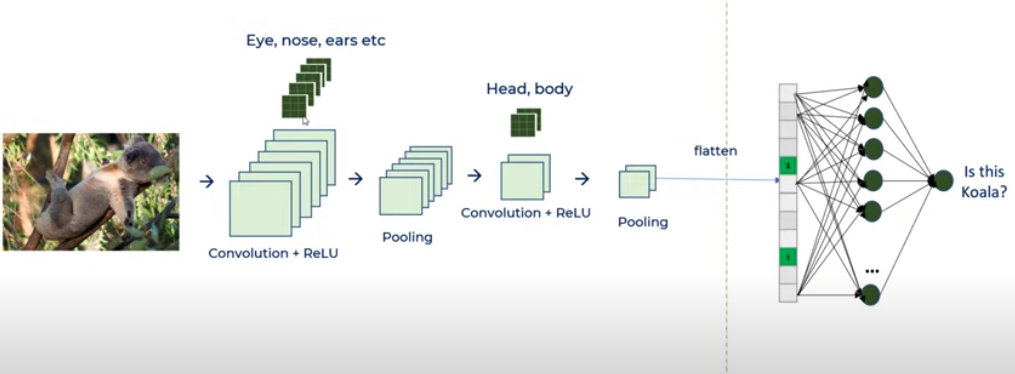

In [ ]:
model = Sequential()

# Feature Extraction
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Classification
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [ ]:
model.summary()

### Loss functions: 

Son funciones matematicas para medir qué tan bien se desempeña tu deep learning model.

Usamos `binary_crossentropy` como loss function. Esta función toma las probabilidades predichas y las reales de cada clase, y calcula la entropía cruzada entre estas.

Para más información: https://machinelearningmastery.com/cross-entropy-for-machine-learning/

### Optimizers

Son clases o métodos que se utilizan para cambiar los atributos de tu deep learning model, como weigths y learning rate, con el fin de reducir tu loss (perdida).

Los optimizadores ayudan a obtener resultados más rápido.

Usamos `Adam` como optimizer. Adam es el mejor entre los optimizadores adaptativos en la mayoría de los casos.

Para más información: https://analyticsindiamag.com/guide-to-tensorflow-keras-optimizers/

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#### Lectura de datos
- Definimos ImageDataGenerators para cada conjunto de datos (train, test, validation)
- `rescale=1. / 255` escala la matriz de valores de píxeles de la imagen original para que esté entre [0,1]. En píxeles, 0 representa negro y 255 representa blanco.
- Para `train`, usamos Data Augmentation (Aumento de Datos):
    - El aumento de datos hace que el modelo sea más robusto a ligeras variaciones y, por lo tanto, evita que el modelo se sobreajuste (overfitting).
    - Para más info, ver: `notebook/data_augmentation.ipynb`

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [ ]:
test_valid_datagen = ImageDataGenerator(rescale=1. / 255)

- Definimos el tamaño de los baches durante el entrenamiento (número de muestras a procesar antes de actualizar valores en nuestra red)

In [ ]:
batch_size = 5

- Lectura de datos: `.flow_from_directory(...)` asume que cada subdirectorio es una clase diferente.

In [ ]:
# define train, validation, test dirs
train_data_dir = join(DATA_PATH, 'train')
validation_data_dir = join(DATA_PATH, 'validation')
test_data_dir = join(DATA_PATH, 'test')

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

In [ ]:
validation_generator = test_valid_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

In [ ]:
train_generator.class_indices

In [ ]:
test_generator = test_valid_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

### Entrenamos nuestro modelo
- Definimos el número de epochs (veces que completamos un ciclo completo sobre nuestros datos)

In [ ]:
epochs = 5

- Entrenamos nuestra CNN, usando `model.fit_generator(...)`

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // batch_size)

### Evaluación del modelo
- Validation Loss y Accuracy

In [ ]:
history.history.keys()

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

- Rendimiento del modelo sobre datos de prueba (Test set)

In [ ]:
scores = model.evaluate(test_generator)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

### Exportamos el modelo

In [ ]:
if not os.path.exists(join(DATA_PATH, 'model')):
    os.makedirs(join(DATA_PATH, 'model'))

model.save(join(DATA_PATH, 'model/cnn_model'))